In [ ]:
import ast
import gzip
import json
import random
from pathlib import Path
from typing import Generator, List, Literal, Optional, Tuple

import pandas as pd
from Bio import Seq, SeqIO
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
from pathlib import Path

random.seed(42)

In [ ]:
class Document:
    def __init__(
        self, sentences: Optional[List[str]] = None, metadata: Optional[dict] = None
    ) -> None:
        """
        Data structure to store subsequences that are forming the chromosome

        Each document contains up to `max(sentence_bound) * max(lengths_bound)` of nts
        """
        if sentences is None:
            self.sentences = []
        else:
            self.sentences = sentences
        self.metadata = metadata

    def append(self, sentence: str) -> None:
        self.sentences.append(sentence)

    def to_text(self) -> str:
        return "\n".join(self.sentences)

    def to_jsonl(self) -> None:
        if self.metadata:
            return json.dumps({"text": self.sentences, **self.metadata})
        else:
            return json.dumps({"text": self.sentences})


def generate_documents(
    chr_sequence: Seq,
    n_augmentations: int,    
    sentences_bounds: Tuple[int] = (50, 100),
    lenghts_bounds: Tuple[int] = (500, 1000),
) -> Generator[Document, None, None]:
    """
    From a single chromosome yield a set of documents that cover that chromosome.
    This operation is done ten-fold. 
    """

    C = len(chr_sequence)  # chromosome length

    for _ in range(n_augmentations):
        q = random.randint(0, 5000)  # random start position from the 5' end
        while q < C:
            #s = random.randint(*sentences_bounds)  # number of sentences per document
            s = 75
            d = Document()
            for _ in range(s):
                #l = random.randint(*lenghts_bounds)  # length of each sentence
                l = 512
                if q+l > C:
                    l = C - q
                d.append(str(chr_sequence[q : q + l]).upper())
                q += l  # update position for the new sentence
                if q>=C: # we reached the end of seq, no more sentences available
                    break
            yield d


def handle_chromosome(
    chr: SeqIO.SeqRecord,
    outdir: Path,
    n_augmentations: int,
    io_mode: Literal["single_txt", "jsonl", "multiple_txt"] = "single_txt",
):
    """
    For a given chromosome make documents and write them to corresponding files
    """

    if io_mode == "single_txt":
        filename = outdir / f"{chr.name}_documents.txt"
        with filename.open(mode="w") as out:
            for document in generate_documents(chr.seq, n_augmentations=n_augmentations, lenghts_bounds=512, sentences_bounds=50):
                out.write(document.to_text())
                out.write("\n")
    elif io_mode == "jsonl":
        filename = outdir / f"{chr.name}_documents.jsonl"
        with open(filename, mode="w") as out:
            for document in generate_documents(chr.seq, n_augmentations=n_augmentations):
                out.write(document.to_jsonl())
                out.write("\n")
    elif io_mode == "multiple_txt":
        for idx, document in enumerate(generate_documents(chr.seq, n_augmentations=n_augmentations)):
            filename = outdir / f"{chr.name}_document_{idx}.txt"
            with filename.open(mode="w") as out:
                out.write(document.to_text())


def read_single_fasta(fna_file: Path, n_augmentations: int, output_dir: Optional[Path] = None,
                      contigs_split_file: Optional[Path] = None,
                      io_mode: Literal["single_txt", "jsonl", "multiple_txt"] = "single_txt",
                      min_len: Optional[int] = 10000,
                      rc: Optional[bool] = False,
                      ):
    if not output_dir:
        output_dir = Path(".")

    if contigs_split_file is not None:
        contigs = pd.read_csv(contigs_split_file, dtype=str)
        if len(contigs) == 0: # no contig split data available
            contigs_split_file = None
        else:
            contigs = contigs.set_index("name")
            contigs["intervals"] = contigs["intervals"].apply(ast.literal_eval)

    if fna_file.endswith(".gz"):
        fasta_open = gzip.open
    else:
        fasta_open = open
    
    with fasta_open(fna_file,"rt") as input_handle:
        for record in tqdm(SeqIO.parse(input_handle, "fasta")):
            if rc:
                record.name  = "rc_" + record.name # modify record name to have different names of rc-files later
            if ("mitochondrion" not in record.description) and len(record.seq) >= min_len:
                if contigs_split_file is not None:
                    chr_contigs = contigs.loc[record.id,"intervals"]
                    for contig in chr_contigs:
                        contig_start = contig[0]
                        contig_end = contig[1]
                        if contig_end-contig_start < min_len:
                            continue
                        contig_name = "_c"+str(contig_start)+"_"+str(contig_end)
                        if rc:
                            seq = record.seq[contig_start:contig_end]
                        else:
                            seq = Seq.reverse_complement(record.seq[contig_start:contig_end])
                        seq_record = SeqRecord(seq = seq,
                                                id = record.id+contig_name,
                                                name = record.name+contig_name,
                                                description = record.description+contig_name)
                        handle_chromosome(seq_record, outdir=output_dir, io_mode=io_mode,
                                          n_augmentations=n_augmentations)
                else:
                    if rc:
                        record.seq = record.seq.reverse_complement()
                    handle_chromosome(record, outdir=output_dir, io_mode=io_mode, n_augmentations=n_augmentations)

def create_dataset(input_file, contigs_split_file, output_dir, io_mode, min_len, n_augmentations):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    assert n_augmentations>0, "The number of augmentations should be > 0"
    read_single_fasta(input_file, contigs_split_file=contigs_split_file, 
                        output_dir=output_dir, io_mode=io_mode,
                        min_len=min_len, n_augmentations=n_augmentations)

In [9]:
input_file = "/projects/slmreasoning/yifang/datasets/GRCh38/human_GRCh38.p13.fna"
contigs_split_file = None
output_dir = "/projects/slmreasoning/yifang/datasets/GRCh38/processed_data/"
io_mode = "jsonl"
min_len = 10000
n_augmentations = 1

create_dataset(input_file, contigs_split_file, output_dir, io_mode, min_len, n_augmentations)

639it [02:15,  4.71it/s]


共收集了 4361493 条句子
示例句子： ['GAAACCCATCTCACGTGCAGAGACACACATAGACTCAAAATAAAGGGATGGAAGAAGATCTACCAAGCAAATGGAAAACAAAAAAAGGCAGGGTTTGCAATCCTAGTCTCTGATAAAATAGACTTTAAACCAACAAAGATCAAAAGAGACAAAGAAGGCCTTTACATAATGGTAAAGGGATCAATTCAACAAGAAGAGCTAACTATCCTACATATATATGCACCCAATACAGGAGCACCCAGATTCCTAAAGCAAGTCCTGAGTGACCTACAAAGAGACTTAGACTCCCCCACAATCATAATGGGAGATTTTAACACGCCACTGTCAACATTAGACAGATCAACGAGACAGAAAGTTAACAAGGATACCCAGGAATTGAACTCAGCTCTGCACCAAGCACACCTAATAGACATCTACAGAACTCTCGACCCCAAATCAACAGAATATACATTTTTTTCAGCACCACACCACACCCATTCTAAACGTGATCACATAGTTGGAAGTAAAGCTCTCCTCAGCAAATATAAAAGAACAGAAATTATAACAAACTGTCTCGCAGACCACAGTGCAATCAAACTAGAACTCAGGATTAAGAAACTCACTCAAAACCGCTCAACTACATGGAAAATGAACAACCTGCTCCGGAATGACCACTGGGTACATAACAAAATGAAGGCAGAAATAAAGATGTTGTTTGAAACCAACGAGAACAAAGACAAAACATACCAGAATCTCTGGGACACACTCAAAGCAGTGTGTAGAGGGAAATTTATAGCACTAAATGCCCACAAGAGAAAGCAGGAAAGATCCAAAATTGACACCCTAACATCACAATTAAAAGAACTTGAAAAGC', 'AAGAGCAAACACATTCAAAAGCTAGCAGAAGGCAAGAAATAACTAAAATCGAGCAGAACTGAAGGAAATAGAGACACAAAAAACCCTTCAAAAAACTAATGAATCCAGCAGCTGGTTT

/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 21477 (\N{CJK UNIFIED IDEOGRAPH-53E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_305486/3868998923.py:39: UserWarning: Glyph 30897 (\N{CJK UNIFIED IDEOGRAPH-78B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/localscratch/ipykernel_3054

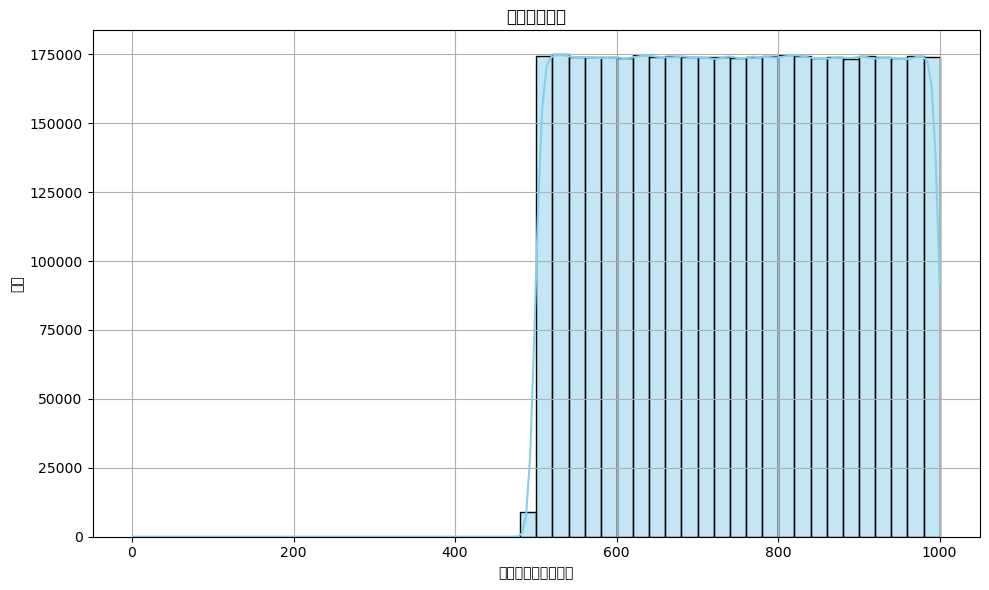

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

folder = Path("/projects/slmreasoning/yifang/datasets/GRCh38/processed_data")
output_file = folder / "all_sentences.jsonl"

all_sentences = []

for jsonl_file in folder.glob("*.jsonl"):
    with open(jsonl_file, "r") as f:
        for line in f:
            doc = json.loads(line)
            all_sentences.extend(doc["text"])

print(f"Number of sentences collected: {len(all_sentences)} ")
print("Examples:", all_sentences[:5])


lengths = [len(sentence) for sentence in all_sentences]
average_length = sum(lengths) / len(lengths) if lengths else 0
print(f"Average Sentence Length: {average_length:.2f}")

with open(output_file, "w") as f:
    for sentence in all_sentences:
        json.dump({"text": sentence}, f)
        f.write("\n")
print(f"All sentences saved to {output_file}")

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=50, kde=True, color="skyblue")
plt.title("Length Distribution of Sentences")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import json
from pathlib import Path

jsonl_file = Path("/projects/slmreasoning/yifang/datasets/GRCh38/processed_data/all_sentences.jsonl")

sentences = []

with open(jsonl_file, "r") as f:
    for line in f:
        obj = json.loads(line)  # 每行是一个 {"text": sentence}
        sentences.append(obj["text"])

print(f"共读取了 {len(sentences)} 条句子")
print("前5条示例：", sentences[:5])


共读取了 4361493 条句子
前5条示例： ['GAAACCCATCTCACGTGCAGAGACACACATAGACTCAAAATAAAGGGATGGAAGAAGATCTACCAAGCAAATGGAAAACAAAAAAAGGCAGGGTTTGCAATCCTAGTCTCTGATAAAATAGACTTTAAACCAACAAAGATCAAAAGAGACAAAGAAGGCCTTTACATAATGGTAAAGGGATCAATTCAACAAGAAGAGCTAACTATCCTACATATATATGCACCCAATACAGGAGCACCCAGATTCCTAAAGCAAGTCCTGAGTGACCTACAAAGAGACTTAGACTCCCCCACAATCATAATGGGAGATTTTAACACGCCACTGTCAACATTAGACAGATCAACGAGACAGAAAGTTAACAAGGATACCCAGGAATTGAACTCAGCTCTGCACCAAGCACACCTAATAGACATCTACAGAACTCTCGACCCCAAATCAACAGAATATACATTTTTTTCAGCACCACACCACACCCATTCTAAACGTGATCACATAGTTGGAAGTAAAGCTCTCCTCAGCAAATATAAAAGAACAGAAATTATAACAAACTGTCTCGCAGACCACAGTGCAATCAAACTAGAACTCAGGATTAAGAAACTCACTCAAAACCGCTCAACTACATGGAAAATGAACAACCTGCTCCGGAATGACCACTGGGTACATAACAAAATGAAGGCAGAAATAAAGATGTTGTTTGAAACCAACGAGAACAAAGACAAAACATACCAGAATCTCTGGGACACACTCAAAGCAGTGTGTAGAGGGAAATTTATAGCACTAAATGCCCACAAGAGAAAGCAGGAAAGATCCAAAATTGACACCCTAACATCACAATTAAAAGAACTTGAAAAGC', 'AAGAGCAAACACATTCAAAAGCTAGCAGAAGGCAAGAAATAACTAAAATCGAGCAGAACTGAAGGAAATAGAGACACAAAAAACCCTTCAAAAAACTAATGAATCCAGCAGCTGGTT

In [ ]:
from torch.utils.data import DataLoader
from dataset import DNADataset

dataset = DNADataset(sentences, seq_len=512, mode="masked")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 检查一个 batch
for batch in dataloader:
    x, y = batch
    print(x.shape)  # e.g. (32, 512)
    print(y.shape)
    print(x[0])
    break

torch.Size([32, 512])
torch.Size([32, 512])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,